In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

pd.set_option('display.max_rows', 100)

In [2]:
oura = pd.read_csv(
    "data/oura.csv",
    index_col="day",
    parse_dates=True,
    usecols=[
        "day",
        "deep_sleep_duration",
        "rem_sleep_duration",
        "light_sleep_duration",
        "total_sleep_duration",
        "type",
    ],
)
# only keep sleeps
oura = oura[oura.type == "long_sleep"]
# # convert to timedelta
duration_cols = [
    "deep_sleep_duration",
    "rem_sleep_duration",
    "light_sleep_duration",
    "total_sleep_duration",
]
oura[duration_cols] = oura[duration_cols].apply(pd.to_timedelta, args=("S"))

In [3]:
def detect_activity(row, activity_list):
    new_row = row
    mask = [1 if activity in row["activities"] else 0 for activity in activity_list]
    new_row[3:] = mask
    return new_row

daylio = pd.read_csv(
    "data/daylio.csv",
    usecols=["full_date", "weekday", "mood", "activities"],
    index_col="full_date",
    parse_dates=True,
)
# parse activities
unique_activities = (
    daylio["activities"].str.split(r"\s*\|\s*", expand=True).stack().unique()
)
daylio["activities"] = daylio.activities.apply(lambda x: x.split(" | "))
for activity in unique_activities:
    daylio[activity] = 0
daylio = daylio.apply(lambda x: detect_activity(x, unique_activities), axis=1)
daylio.drop(columns="activities", inplace=True)
# convert moods to ordinal
mood_map = {"awful": -2, "bad": -1, "meh": 0, "good": 1, "rad": 2}
inv_mood_map = {v:k for k,v in mood_map.items()}
daylio.mood =  daylio.mood.map(mood_map)

/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_18854/4211753255.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daylio[activity] = 0
/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_18854/4211753255.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daylio[activity] = 0


In [4]:
# join dfs
headache_sleep = daylio.join(oura).dropna()

/var/folders/my/lvxg1n852nq3vf2vvjqcrzp80000gn/T/ipykernel_18854/3847040540.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


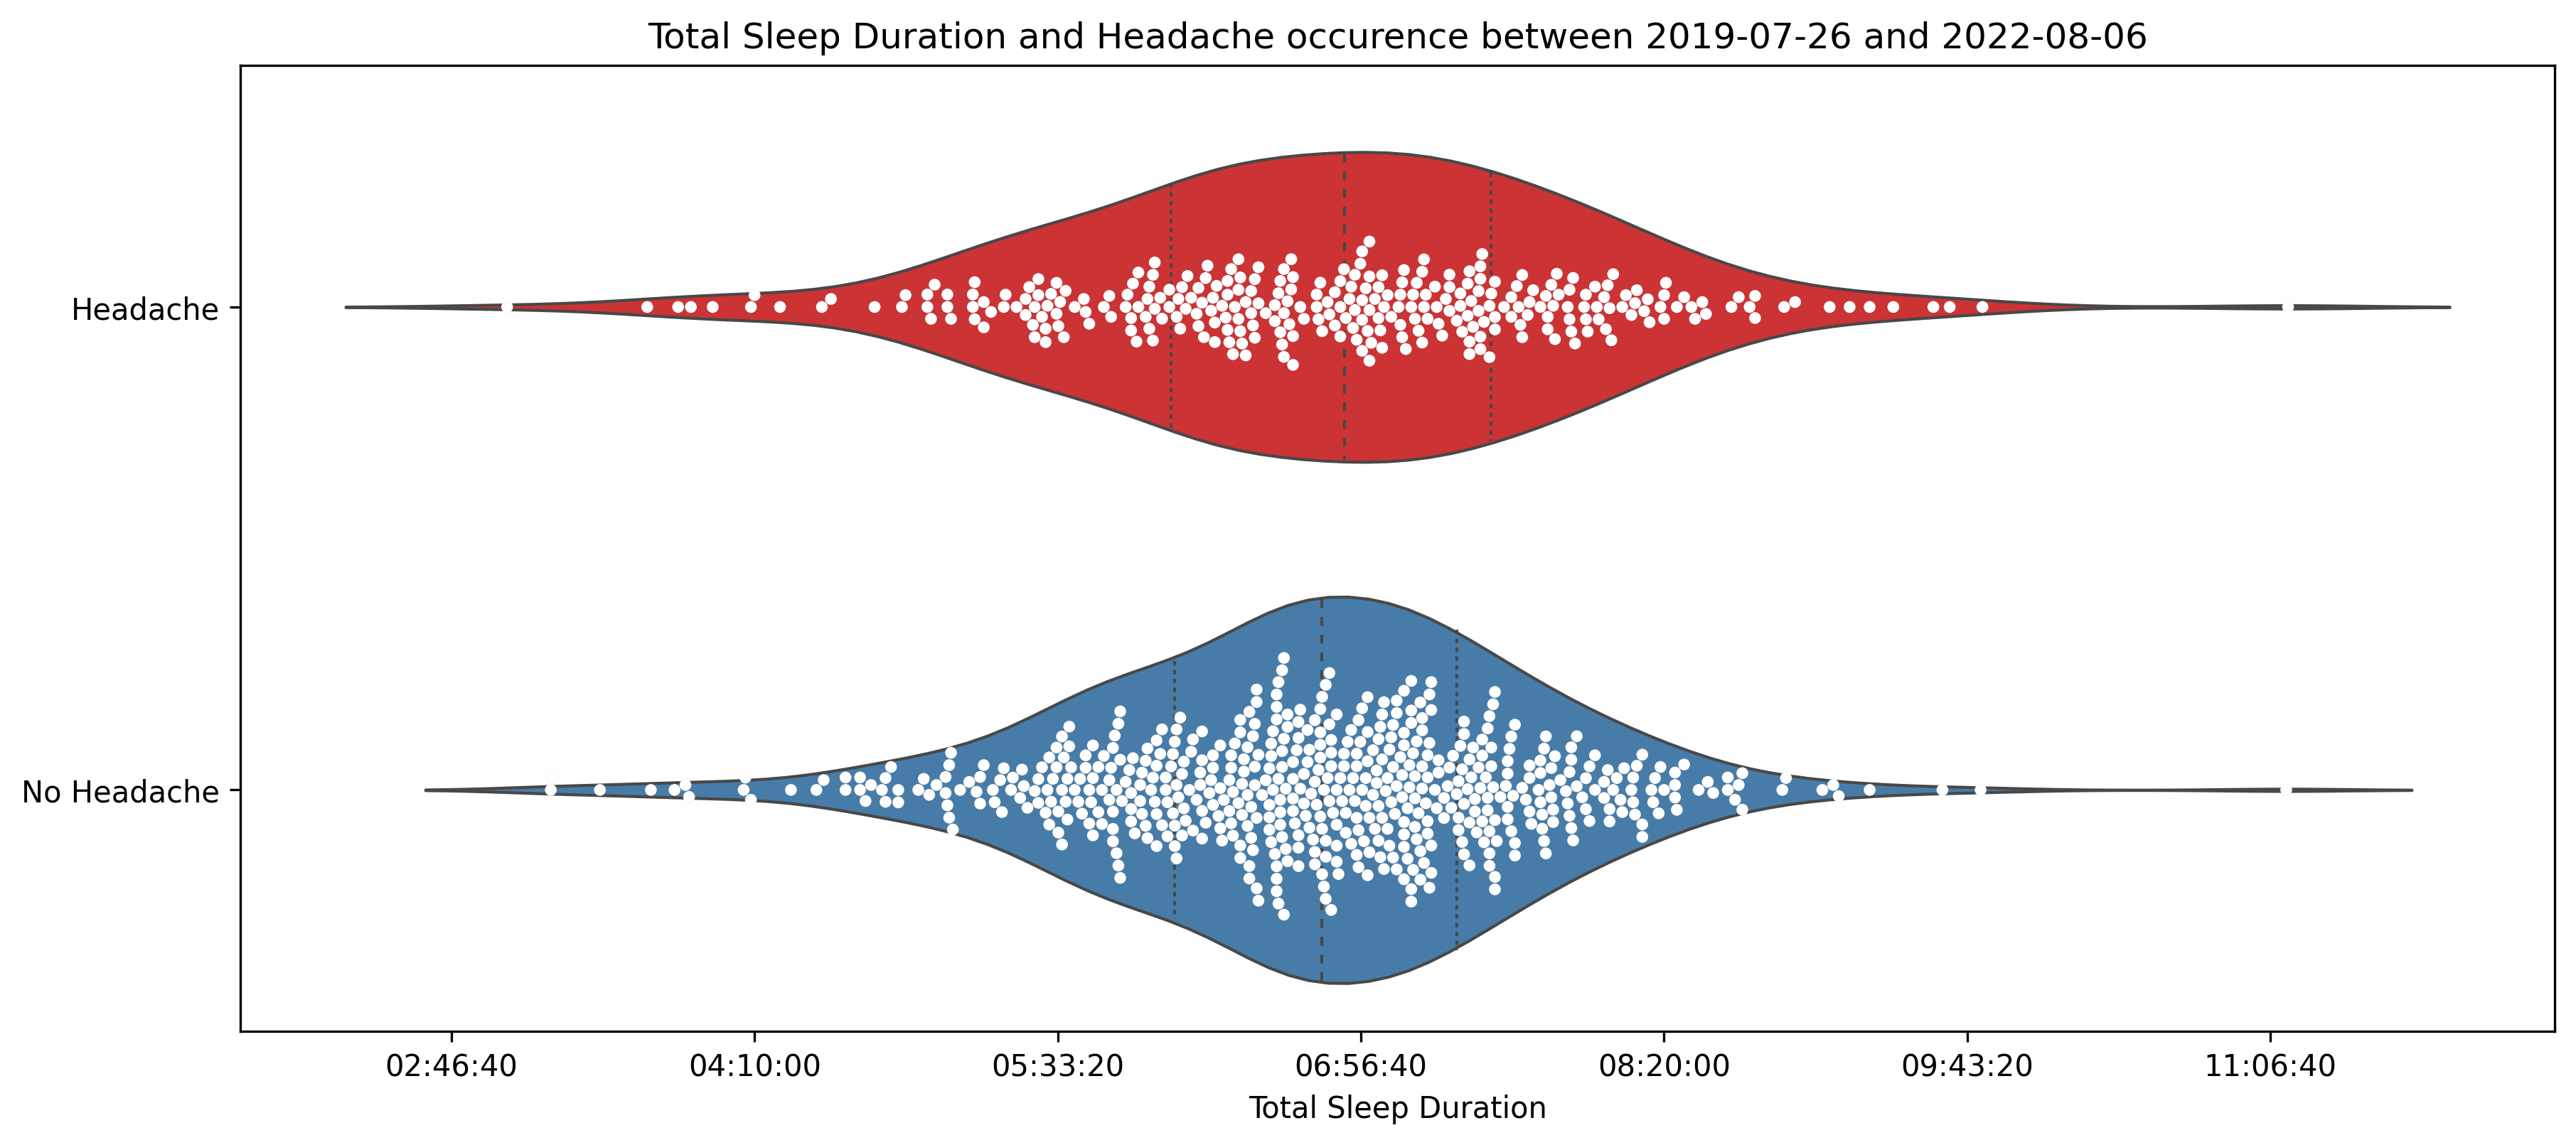

In [5]:
f, ax = plt.subplots(1, 1, figsize=(14, 6), dpi=300)
sleep_type = "Total"
sleep_duration_series = headache_sleep[
    f"{sleep_type.lower()}_sleep_duration"
].dt.total_seconds()

sns.violinplot(
    y=headache_sleep.Headache,
    x=sleep_duration_series,
    orient="h",
    scale="area",
    inner="quartile",
    linewidth=1,
    order=[1, 0],
    palette="Set1",
)
sns.swarmplot(
    y=headache_sleep.Headache,
    x=sleep_duration_series,
    orient="h",
    color="white",
    size=4,
    edgecolor="black",
    order=[1, 0],
    linewidth=0.01,
)
ax.set_xticklabels(
    [time.strftime("%H:%M:%S", time.gmtime(tick)) for tick in ax.get_xticks()]
)
ax.set_xlabel(f"{sleep_type} Sleep Duration")

ax.set_yticklabels(["Headache", "No Headache"])
ax.set_ylabel(None)

ax.set_title(
    f"{sleep_type} Sleep Duration and Headache occurence between "
    f"{headache_sleep.index.min().date()} and {headache_sleep.index.max().date()}"
)

plt.savefig(
    f"/Users/thesofakillers/Desktop/headache_{sleep_type}_sleep.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
)
plt.show()